In [1]:
import pandas as pd
import sympy as sy
import matplotlib.pyplot as plt
import numpy as np
import incerts as inc
from scipy.optimize import curve_fit

In [2]:
#   Defining symbols
x, y = sy.symbols('x y')

In [3]:
#   Defining global constants
E  = 8.85
r = 8.56e-3 / 2
sr = 0.01e-3
A = np.pi * r**2
sA = np.pi * inc.incerts(x**2, [x], [r], [sr])
d = 1.86e-3
sd = 0.01e-3

C0 = E * A / d
sC0 =  E * inc.incerts(x/y, [x, y], [A, d], [sA, sd])


Text(0, 0.5, 'C / pF')

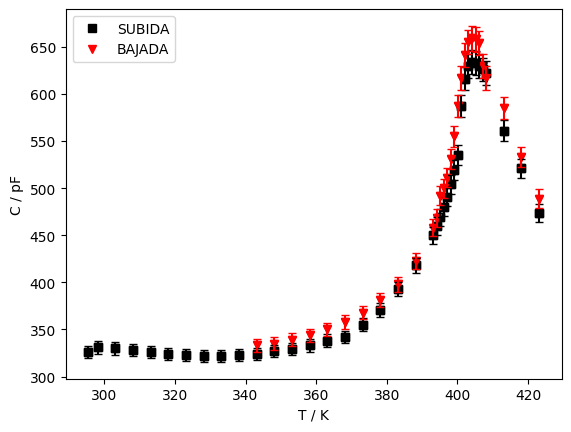

In [4]:
#   Load data
data = pd.read_csv('FES_Curie.csv')

#   Plot C - T

ax = plt.gca()

data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float)
data['BAJADA'] = data['BAJADA'].astype(float)
sC_S = 0.02 * data['SUBIDA'].astype(float)
sC_B = 0.02 * data['BAJADA'].astype(float)

sub = data.plot(x = 'T', y = 'SUBIDA', ax = ax, style = 'ks')
baj = data.plot(x = 'T', y = 'BAJADA', ax = ax, style = 'rv')
plt.errorbar(x = data['T'], y = data['SUBIDA'], yerr = sC_S, barsabove=True, capsize = 3, fmt = 'ks')
plt.errorbar(x = data['T'], y = data['BAJADA'], yerr = sC_B, barsabove=True, capsize = 3, fmt = 'rv')
ax.set_xlabel('T / K')
ax.set_ylabel('C / pF')

In [44]:
#   Define C-W function for fit
def cw(T, C, Tc):
    return 1 + C / (T - Tc)
def pol(T, a, b, c, d, e):
    return a * T**4 + b * T**3 +c * T**2 + d * T + e
def logauss(T, a, b, c):
    return a * np.exp(-(np.log(T)-b)**2/(2*c**2))
def pois (T, a, l):
    return a * l**T * np.exp(-l) / sy.factorial(T)

404.15
404.15


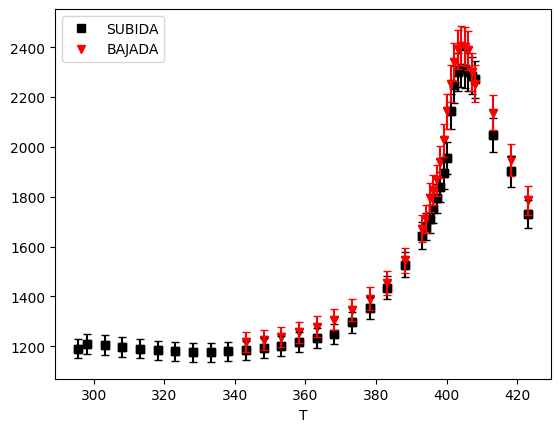

In [54]:
#   Plot \epsilon - T and fitting through C-W
data = pd.read_csv('FES_Curie.csv')
ax = plt.gca()
data = data.reset_index()

data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float) / C0
data['BAJADA'] = data['BAJADA'].astype(float) / C0

start = data['BAJADA'].first_valid_index()

sE_S = []
for i in range (len (data['SUBIDA'])):
    sE_S.append(inc.incerts(x / y, [x, y], [data['SUBIDA'].loc[i], C0], [sC_S.loc[i], sC0]))

sE_B = []
for i in range (len (data['BAJADA'].loc[start:])):
    sE_B.append(inc.incerts(x / y, [x, y], [data['BAJADA'].loc[i + start], C0], [sC_B.loc[i + start], sC0]))

max_index_S = np.argmax(data['SUBIDA'])
max_index_B = np.argmax(data['BAJADA'])

sub = data.plot(x = 'T', y = 'SUBIDA', ax = ax, style = 'ks')
baj = data.plot(x = 'T', y = 'BAJADA', ax = ax, style = 'rv')
plt.errorbar(x = data['T'], y = data['SUBIDA'], yerr = sE_S, barsabove=True, capsize = 3, fmt = 'ks')
plt.errorbar(x = data['T'].loc[start:], y = data['BAJADA'].loc[start:], yerr = sE_B, barsabove=True, capsize = 3, fmt = 'rv')


print (data['T'].loc[max_index_B])
print (data['T'].loc[max_index_S])

#fit_S, cov_S = curve_fit (logauss, data['T'].loc[data.index[data['T'] == 395.15][0]:], data['SUBIDA'].loc[data.index[data['T'] == 395.15][0]:], p0 = [2e3, 400, 10])
#
#x_fit = np.linspace (395, 420, 500)
#y_fit = logauss (x_fit, fit_S[0], fit_S[1], fit_S[2])
#ax.plot(x_fit, y_fit)
#print(x_fit[np.argmax(y_fit)])

C_subida =  114932.40450586211
C_bajada =  133912.23071178602
Tc_subida =  357.17902222373317
Tc_bajada =  349.1327541444655


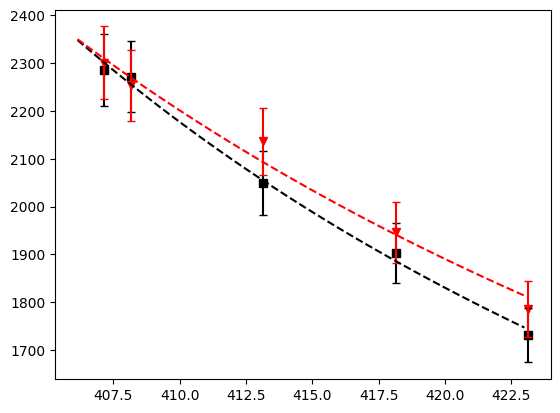

In [66]:
#   Curie-Weiss fit for T>Tc

Tc = 406.15

fit_S, cov_S = curve_fit (cw, data['T'].loc[data.index[data['T'] > Tc][0]:], data['SUBIDA'].loc[data.index[data['T'] > Tc][0]:])
fit_B, cov_B = curve_fit (cw, data['T'].loc[data.index[data['T'] > Tc][0]:], data['BAJADA'].loc[data.index[data['T'] > Tc][0]:])



ax.plot(data['T'].loc[data.index[data['T'] > Tc][0]:], data['SUBIDA'].loc[data.index[data['T'] > Tc][0]:])
ax.plot(data['T'].loc[data.index[data['T'] > Tc][0]:], data['BAJADA'].loc[data.index[data['T'] > Tc][0]:])
plt.errorbar(x = data['T'].loc[data.index[data['T'] > Tc][0]:], y = data['SUBIDA'].loc[data.index[data['T'] > Tc][0]:], yerr = sE_S[data.index[data['T'] > Tc][0]:], barsabove=True, capsize = 3, fmt = 'ks')
plt.errorbar(x = data['T'].loc[data.index[data['T'] > Tc][0]:], y = data['BAJADA'].loc[data.index[data['T'] > Tc][0]:], yerr = sE_B[-5:], barsabove=True, capsize = 3, fmt = 'rv')

x_fit = np.linspace (Tc, 423, 100)

y_fit_S = cw (x_fit, fit_S[0], fit_S[1])
y_fit_B = cw (x_fit, fit_B[0], fit_B[1])


plt.plot(x_fit, y_fit_S, 'k--')
plt.plot(x_fit, y_fit_B, 'r--')

print('C_subida = ', fit_S[0])
print('C_bajada = ', fit_B[0])
print('Tc_subida = ', fit_S[1])
print('Tc_bajada = ', fit_B[1])